### Sequential Learning for Multi-Channel Wireless Network Monitoring With Channel Switching Costs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import numpy as np
from math import pi
import itertools
import random

In [2]:
class AP:
    count = 0
    
    def __init__(self, x, y, channel):
        AP.count += 1
        self.x = x
        self.y = y
        self.channel = channel
        self.radius = 86

    def __str__(self):
        return "AP at (" + str(self.x) + ", " + str(self.y) + ") and channel " + str(self.channel)
        
    def in_hexagon(self, x, y):
        x = abs(x - self.x)
        y = abs(y - self.y)
        s = self.radius
        return y < 3**0.5 * min(s - x, s / 2)


class Sniffer:
    count = 0
    
    def __init__(self, x, y):
        Sniffer.count += 1
        self.x = x
        self.y = y
        self.channel = 0
        self.radius = 120
        self.assigned_user = -1
        
    def __str__(self):
        return "Sniffer at ("+ str(self.x) + ", " + str(self.y) + ") and channel " + str(self.channel)
        
    def in_range(self, x, y):
        x = abs(x - self.x)
        y = abs(y - self.y)
        r = self.radius
        return pow(x,2.0) + pow(y,2.0) <= pow(r,2.0)
    
    def in_range_users(self, users):
        range_users = []
        for user in users:
            if self.in_range(user.x, user.y):
                range_users.append(user) 
#                 print(user)
        return range_users

    def assign_channel(self, channel):
        self.channel = channel
    
    def assign_user(self, channel, users):
        inrange_users = self.in_range_users(users)
#         inrange_users = random.shuffle(inrange_users)
        if(inrange_users is not None):
            for i,user in enumerate(inrange_users):
                if user.active and user.channel == self.channel:
                    self.assigned_user = i
                    break
        else:
            self.assigned_user = -1
            
        
class User:
    count = 0
    
    def __init__(self, x, y):
        User.count += 1
        self.x = x
        self.y = y
        self.channel = 0  
        self.active = 0
        self.activity_prob = 0.3
        
    def __str__(self):
        return "User at ("+ str(self.x) + ", " + str(self.y) + ") and channel " + str(self.channel) + " and active " + str(self.active)
    
    def in_range_sniffers(self, sniffers):
        range_sniffers = []
        for snif in sniffers:
            if snif.in_range(self.x, self.y):
                range_sniffers.append(snif)
        return range_sniffers
    
    def access_point_in_range(self, aps):
        req = []
        for ap in aps:
            if ap.in_hexagon(self.x, self.y):
                self.channel = ap.channel
                break; 
                
    def change_active(self):
        if np.random.rand() <= self.activity_prob:
            self.active = 1
        else:
            self.active = 0     

In [3]:
sniffers = []
for i in range(0, 300, 100):
    for j in range(0, 300, 100):
        sniffers.append(Sniffer(i,j))

In [4]:
aps = []
for i in range(0, 300, 86*3):
    for j in range(0, 300, 86*2):
        aps.append(AP(i,j,(i+j)%3))
        
for i in range(86+int(86/2), 300, 86*3):
    for j in range(-86, 300+86, 86*2):
        aps.append(AP(i,j, (i+j)%3))

In [5]:
users = []
for i in range(0, 100):
        x = np.random.uniform(low=0, high=300, size=(1,))[0]
        y = np.random.uniform(low=0, high=300, size=(1,))[0]
        now = User(x, y)
        now.access_point_in_range(aps)
        now.change_active()
        users.append(now)

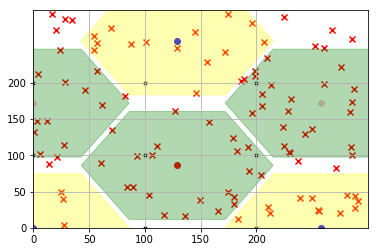

In [6]:
x = [a.x for a in sniffers]
y = [a.y for a in sniffers]

x0 = []
x1 = []
x2 = []
y0 = []
y1 = []
y2 = []

for a in aps:
    if a.channel == 0:
        x0.append(a.x)
        y0.append(a.y)
    elif a.channel == 1:
        x1.append(a.x)
        y1.append(a.y)
    else:
        x2.append(a.x)
        y2.append(a.y)        


x_u = [a.x for a in users]
y_u = [a.y for a in users]

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, 220, 50))
ax.set_yticks(np.arange(0, 220, 50))

for i, a in enumerate(aps):
    if i%2 ==0:
        circle = RegularPolygon((a.x, a.y), 6, radius=a.radius, color="yellow", orientation=pi/2, alpha=0.3)
    else:
        circle = RegularPolygon((a.x, a.y), 6, radius=a.radius, color="green", orientation=pi/2, alpha=0.3)
    ax.add_patch(circle)
    
plt.scatter(x,y, color='black', marker=".")
plt.scatter(x0,y0, color='blue')    
plt.scatter(x1,y1, color='pink')    
plt.scatter(x2,y2, color='red')    
plt.scatter(x_u,y_u, marker = "x", color = "red")    

ax.set_xlim(0,300 )
ax.set_ylim(0, 300)
plt.grid()
plt.show()

In [7]:
channels = 3

sniffer_assign = [0, 2, 1] # channels of sniffers - spanner picked

user_assign = [1 , 1, -1] # user observed by sniffer i - at every it 

In [8]:
def get_iden(arr, channel):
    global sniffer_assign
    arr = np.array(arr)
    sniffer_assign = np.array(sniffer_assign)
    indices = np.where(arr > 0)[0]
    flag = 1
    for index in indices:
        if channel != sniffer_assign[index]:
            output = 0
            flag = 0
            break
    if flag == 1:
        output = 1
    return output

def get_y(arr, channel):
    global users
    global user_assign
    arr = np.array(arr)
    user_assign = np.array(user_assign)
    indices = np.where(arr > 0)[0]
    start = user_assign[indices[0]]
    if start == -1:
        return 0
    if channel != users[start].channel:
        return 0
    output = 1
    for index in indices[1:]:
        if start != user_assign[index] or user_assign[index] == -1:
            output = 0
            return output
    return output

In [9]:
def generate_phi(user_assign, sniffer_assign):
    n = len(sniffer_assign)
    now = ["".join(seq) for seq in itertools.product("01", repeat=n)]
#     print("bla")
    now.remove("".join([str(0) for i in range(n)]))
    phi = []
    y = []
    for a in now:
        a =  list(map(int, list(a)))
        for channel in range(0, channels):
#             print(a, get_iden(a, channel), get_y(a,channel), channel, sniffer_assign, user_assign)
            phi.append(get_iden(a, channel))
            y.append(get_y(a, channel))
    phi = np.array(phi)
    y = np.array(y)
    return (phi, y)

In [10]:
generate_phi(user_assign, sniffer_assign)

(array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))

In [11]:
spanners = []

for channel in range(0, channels):
    for snif in sniffers:
        snif.assign_channel(channel)
    user_assign = [snif.assigned_user for snif in sniffers]

    sniffer_assign = [snif.channel for snif in sniffers]
    
    spanners.append(generate_phi(user_assign, sniffer_assign)[0])
    print (channel)

0
1
2


In [12]:
timestep = 1000

P = len(sniffers)
K = channels

thetha = np.zeros((2**P - 1)*K)
N = np.zeros((2**P - 1)*K)
epoch_counter = np.zeros((2**P - 1)*K)

alpha = 0.2#check

V = np.zeros(K)
mu = np.zeros(K)


for time in range(timesteps):
    epoch_len -= 1
    
    for user in users:
        user.change_active()
    
    for snif in sniffers:
        snif.assign_user()
        
    user_assign = [snif.assigned_user for snif in sniffers]
    sniffer_assign = [snif.channel for snif in sniffers]
    
    phi, Y = generate_phi(user_assign, sniffer_assign)
    
    N += phi #check zeros
    theta = theta + (Y-theta)*phi/N
    
    if epoch_len is 0:
        epoch_counter += phi
        control = np.argmin(N)
        epoch_len = (1+alpha)**(epoch_counter[control]) - (1+alpha)**(epoch_counter[control]-1)
        
        scale = (alpha*np.log(time))**0.5
        
            
        
        V = mu 
        for r in 
        arm = np.argmax(V)
        
        
    
    
    
    
    

SyntaxError: invalid syntax (<ipython-input-12-072149f95749>, line 43)

In [24]:
class ucb_agent():  
    def __init__(self,k,alpha,sniffers,spanners):
        self.arm_count = k #spanner size
        self.alpha = alpha #param
        self.N = np.ones(((2**sniffers-1)*k))
        self.trials = 1
        self.V = np.zeros((k,))
        self.mean = np.zeros((k,))
        self.theta = np.zeros(((2**sniffers-1)*k))
        self.spanners=spanners
        self.reward = [1]

        
    def get_action(self):
        self.trials += 1
#         scale = (self.alpha*np.log(self.trials))**0.5
#         for i in range(self.arm_count):
#             self.V[i] = self.mean[i] + (scale)*np.sum(((1/self.N)**0.5)*self.spanners[i])
        out = np.argmax(self.V)
        
        self.reward.append((self.mean[out]+(self.trials-1)*self.reward[-1])/self.trials)
#         print (self.mean[out])
        return out
    
    def update_theta(self,Y,phi):
        self.theta = self.theta + (Y-self.theta)*phi/self.N
        self.N = self.N + phi
        
    def update(self,Y,phi):
        scale = (self.alpha*np.log(self.trials))**0.5
        for i in range(self.arm_count):
            self.V[i] = self.mean[i] + (scale)*np.sum(((1/self.N)**0.5)*self.spanners[i])
            self.mean[i] = np.dot(self.theta,self.spanners[i])
#         print (self.mean,self.V)    
        return 
    

In [25]:
spanners = []

for channel in range(0, channels):
    for snif in sniffers:
        snif.assign_channel(channel)
    user_assign = [snif.assigned_user for snif in sniffers]
    sniffer_assign = [snif.channel for snif in sniffers]    
    spanners.append(generate_phi(user_assign, sniffer_assign)[0])


agent = ucb_agent(k = channels, alpha=0.1, sniffers=len(sniffers), spanners=spanners)


for action in range(channels):
    for i in users:
        i.change_active()
    for j in sniffers:
        j.assign_channel(action)
        j.assign_user(1,users)

    user_assign = [snif.assigned_user for snif in sniffers]
    sniffer_assign = [snif.channel for snif in sniffers]
    
    phi, Y = generate_phi(user_assign, sniffer_assign)
    #     get Y
    #     get phi
    agent.update(Y,phi)
    agent.update_theta(Y,phi)
        
        
epoch_len =1
epoch_counter = np.ones((2**len(sniffers) - 1)*channels)
steps = 1000
alpha = 0.1
for t in range(steps):
    epoch_len -= 1
    for i in users:
        i.change_active()
    action = agent.get_action()
    for j in sniffers:
        j.assign_channel(action)
        j.assign_user(1,users)

        
    user_assign = [snif.assigned_user for snif in sniffers]
    sniffer_assign = [snif.channel for snif in sniffers]
    
    phi, Y = generate_phi(user_assign, sniffer_assign)
#     print (epoch_len)
    if epoch_len<0:
        epoch_counter += phi
        control = np.argmin(agent.N)
        epoch_len = (1+alpha)**(epoch_counter[control]) - (1+alpha)**(epoch_counter[control]-1)
        agent.update(Y,phi)
    agent.update_theta(Y,phi)
    
    

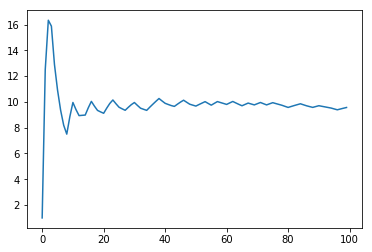

In [27]:
plt.plot(agent.reward[:100])

In [ ]:
p_u = np.random.rand(user_count)
c_u = np.random.randint(low=1,high=channel,size=user_count)
positions_u = np.random.rand(size=(user_count,2))

y = cvxpy.Parameter(user_count,boolean =True)
z = cvxpy.Parameter((user_count,sniffer_count),boolean=True)


con1 = []
for i in range(user_count):
    for j in range_[i]:
        try:
            x = cvxpy.sum(x,z[j,c[u]])
        except:
            x = z[j,c[u]]
    con1.append(y[i]<=x)
    
con2 = []
for i in range(channel):
    con2.append(cvxpy.sum(z[:,i])<=1)

constraints = con1 + con2
obj = cvxpy.Maximize(cvxpy.sum(cvxpy.multiply(p_u,y)))


problem = cvxpy.Problem(objective=obj,constraints=constraints)
problem.solve()
print (z.values)